Notebook to construct the model of the pcm device used to optimize the encoder/decoder -- Ryan Zarcone

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import blahut
import os
from skimage import io, transform

In [2]:
def get_raw_data(path, pcm_device = 'new', device_num=0):
    """
    Load raw data from a path.
    Parameters
    ----------
    path : str
        Absolute path to the data.
    Returns
    -------
    Vs : np.array, shape (len(data),)
    Rs : np.array, shape (len(data),)
    """

    data = pd.read_pickle(path)
    
    if pcm_device == 'new':
        device_idx = [data['Device'] == device_num]
        Vs = np.array(data['V'][device_idx[0]])
        Rs = np.array(data['R'][device_idx[0]])
    else: 
        Vs = np.array(data['V'])
        Rs = np.array(data['R'])
        
    Rs = np.log10(Rs)
    Vs = np.array(Vs)
    Rs = np.array(Rs)
    
    return Vs,Rs

def range_extender(Vs, Rs, num_ext):
    """
    Extends the range of the memristor function so that the min and max R values are
    repeated num_ext times past min and max V
    Parameters
    ----------
    Vs : np.array, shape (len(data),)
    Rs : np.array, shape (len(data),)
    num_ext : float
        Number of times the end values should be repeated
    """
    num_ext = int(num_ext)
    Vs = np.array(Vs)
    Rs = np.array(Rs)
    delta_V = Vs[1]-Vs[0]
    orig_min_Vs = np.amin(Vs)
    orig_max_Vs = np.amax(Vs)
    for i in range(num_ext):
        min_Vs = np.amin(Vs)
        max_Vs = np.amax(Vs)
        min_Vs_indx = [Vs == min_Vs]
        max_Vs_indx = [Vs == max_Vs]
        Rs_min = Rs[tuple(min_Vs_indx)]
        Rs_max = Rs[tuple(max_Vs_indx)]
        Vs_min = Vs[tuple(min_Vs_indx)] - delta_V
        Vs_max = Vs[tuple(max_Vs_indx)] + delta_V
        Vs = np.append(Vs,Vs_min)
        Vs = np.append(Vs,Vs_max)
        Rs = np.append(Rs,Rs_min)
        Rs = np.append(Rs,Rs_max)
    return Vs, Rs, orig_min_Vs, orig_max_Vs

def normalizer(x,new_min,new_max):
    x_max = np.amax(x)
    x_min = np.amin(x)

    return (((x-x_min)/(x_max-x_min))*(new_max-new_min)+new_min)

def get_memristor_data(path, pcm_device, n_mem, num_ext=2, norm_min=-1., norm_max=1., normalize=True):
    """
    Parameters
    ----------
    path : str
        Absolute path to the data.
    n_mem : float
        Number of memristors we want to simulate
    num_ext : float
        Number of times the end values should be repeated (see range_extender)
    Returns
    -------
    vs : np.array, shape (n_samp, n_mem)
    mus : np.array, shape (n_samp, n_mem)
    sigs : np.array, shape (n_samp, n_mem)
    orig_min_Vs : float
    orig_max_Vs : float
    """
    
    if pcm_device == 'new':
        diffs = np.array([0.32,0.4,0.12,0.115,0.235,0.0,0.26])
        device_nums = np.arange(7)
        Vs, Rs = get_raw_data(path, pcm_device = 'new', device_num = 0)
        Rs = Rs+diffs[0]
        for i in device_nums[1:]:
            V_new, R_new = get_raw_data(path, pcm_device = 'new', device_num = device_nums[i])
            Vs = np.append(Vs,V_new)
            Rs = np.append(Rs,R_new+diffs[i])            
    else:
        Vs,Rs = get_raw_data(path, pcm_device = 'old')

    orig_min_Vs = np.amin(Vs)
    orig_max_Vs = np.amax(Vs)
    orig_min_Rs = np.amin(Rs)
    orig_max_Rs = np.amax(Rs)
    
    if normalize: 
        Vs = normalizer(Vs,norm_min,norm_max)
        Rs = normalizer(Rs,norm_min,norm_max)

    Vs, Rs, _, _ = range_extender(Vs,Rs,num_ext)

    mus, sigs, vs = blahut.moments(Vs,Rs)

    vs = np.broadcast_to(vs[:,None], (vs.size, n_mem)).astype(np.float32)
    mus = np.broadcast_to(mus[:,None], (mus.size, n_mem)).astype(np.float32)
    sigs = np.broadcast_to(sigs[:,None], (sigs.size, n_mem)).astype(np.float32)

    return vs, mus, sigs, orig_min_Vs, orig_max_Vs, orig_min_Rs, orig_max_Rs

In [3]:
path = 'PCM_20140605.pkl'
pcm_device = "new"
n_mem = 1

norm_min = -2.
norm_max = 2.

In [4]:
vs, mus, sigs, orig_min_Vs, orig_max_Vs, orig_min_Rs, orig_max_Rs = get_memristor_data(pcm_device = pcm_device, 
                                                                                              path=path, 
                                                                                              n_mem=n_mem, 
                                                                                              norm_min=norm_min, 
                                                                                              norm_max=norm_max)

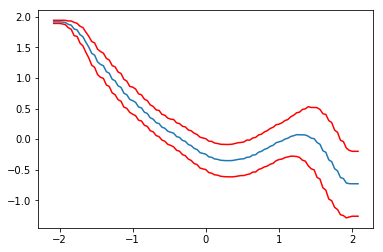

In [5]:
plt.plot(vs, mus+sigs, c="red")
plt.plot(vs, mus)
plt.plot(vs, mus-sigs, c="red")